In [1]:
#importing python spark library
from pyspark.sql import SparkSession

In [2]:
#Creating a spark session
spark= SparkSession.builder.appName('Project').getOrCreate()

In [44]:
#importing all the tools which will be required in data prepretion and creating layers 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer , OneHotEncoder
from pyspark.ml.feature import MinMaxScaler , StandardScaler , VectorAssembler

In [5]:
#importing the LinearRegression Model and crossValidator for model tunning.
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [6]:
#importing the RegressionEvaluator for evaluating our model.
from pyspark.ml.evaluation import RegressionEvaluator

In [7]:
#importing functions
from pyspark.sql.functions import isnan,when,count,col

In [8]:
from pyspark.ml import Pipeline

In [11]:
#reading the file
df=spark.read.csv('insurance.csv', header=True,inferSchema=True)

In [12]:
#showing the data
df.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [13]:
#all the Columns
df.columns

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [14]:
#data type in each columns 
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [15]:
#understanding Charges column 
df.select("charges").show(5)

+-----------+
|    charges|
+-----------+
|  16884.924|
|  1725.5523|
|   4449.462|
|21984.47061|
|  3866.8552|
+-----------+
only showing top 5 rows



In [16]:
#understanding region column 
df.select("region").show(5)

+---------+
|   region|
+---------+
|southwest|
|southeast|
|southeast|
|northwest|
|northwest|
+---------+
only showing top 5 rows



In [17]:
#understanding BMI column 
df.select("bmi").show(5)

+------+
|   bmi|
+------+
|  27.9|
| 33.77|
|  33.0|
|22.705|
| 28.88|
+------+
only showing top 5 rows



In [18]:
#total count of rows
df.count()

1338

In [19]:
#checking charges Column if they have any unique values
df.groupby('charges').count().show()

+-----------+-----+
|    charges|count|
+-----------+-----+
|  9361.3268|    1|
|   2494.022|    1|
|   7441.501|    1|
| 11353.2276|    1|
|   7954.517|    1|
|  1705.6245|    1|
|  2523.1695|    1|
| 2803.69785|    1|
| 8017.06115|    1|
| 12231.6136|    1|
| 10560.4917|    1|
|  1163.4627|    1|
|45702.02235|    1|
|  15170.069|    1|
| 3279.86855|    1|
| 1632.03625|    1|
| 17748.5062|    1|
|36910.60803|    1|
| 12949.1554|    1|
|   1743.214|    1|
+-----------+-----+
only showing top 20 rows



In [20]:
#checking null values in charges
df.select('*').where(df.charges.isNull()).count()

0

In [21]:
#checking null value in each calumns with the help of a loop
def get_null_value_count(data):
    data.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in data.columns]).show()

In [22]:
#NO null value in any culumns. 
get_null_value_count(df)

+---+---+---+--------+------+------+-------+
|age|sex|bmi|children|smoker|region|charges|
+---+---+---+--------+------+------+-------+
|  0|  0|  0|       0|     0|     0|      0|
+---+---+---+--------+------+------+-------+



### DATA VISUALIZATION

+------+-----+
|smoker|count|
+------+-----+
|    no| 1064|
|   yes|  274|
+------+-----+



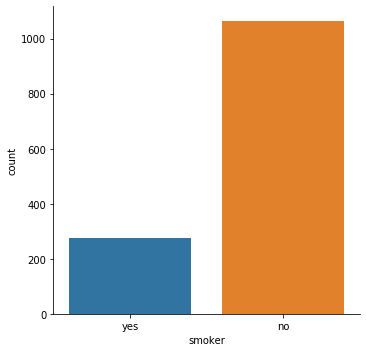

In [41]:
df.groupby('smoker').count().show()
dx = df.toPandas()
sns.catplot(x='smoker', kind='count', data=dx)

+--------+-----+
|children|count|
+--------+-----+
|       1|  324|
|       3|  157|
|       5|   18|
|       4|   25|
|       2|  240|
|       0|  574|
+--------+-----+



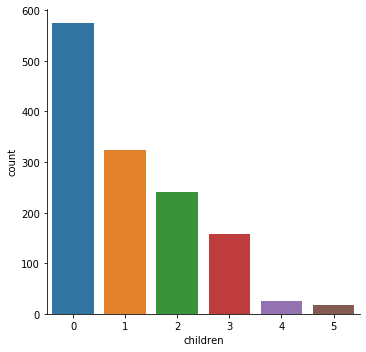

In [42]:
df.groupby('children').count().show()
sns.catplot(x='children', kind='count', data=dx)

BMI less than 25: 247
BMI greater than 25: 1091


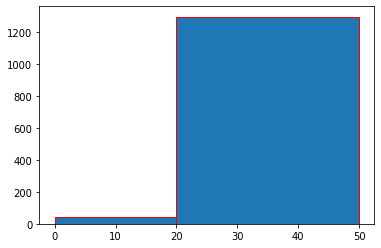

In [46]:
lt=0
mt=0
for i in dx['bmi']:
    if (i<=25):
        lt+=1
    else:
        mt+=1
print('BMI less than 25:', lt)
print('BMI greater than 25:', mt)
plt.hist(dx.bmi, bins=[0,20,50],edgecolor='red')
plt.show()

Text(0.5, 1.0, 'Age Vs BMI')

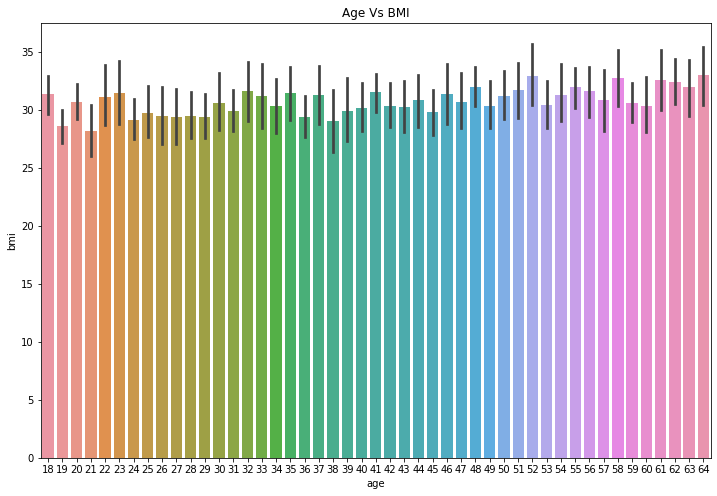

In [47]:
plt.figure(figsize=(12,8))
sns.barplot(x='age',y='bmi', data=dx)
plt.title('Age Vs BMI')

Text(0.5, 1.0, 'Age Vs Charges')

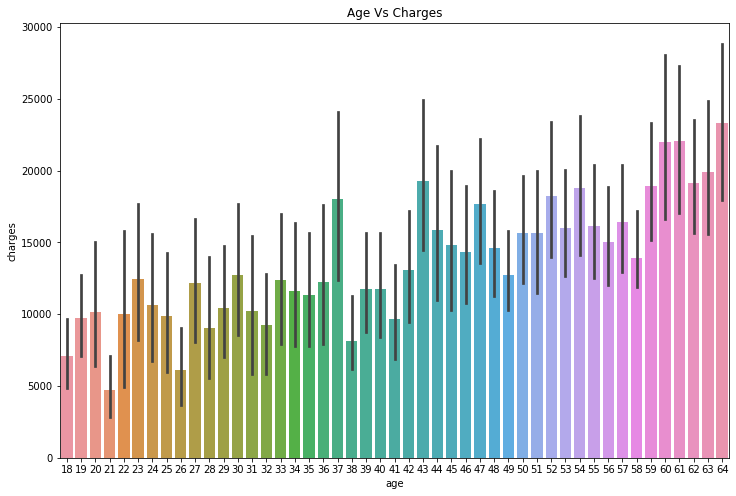

In [48]:
plt.figure(figsize=(12,8))
sns.barplot(x='age',y='charges', data=dx)
plt.title('Age Vs Charges')

In [23]:
#converting string columns to numeric with the help of string indexer
indexer=StringIndexer(inputCols=["sex","smoker","region"],outputCols=["sex_numeric","smoker_numeric","region_numeric"])
df_r=indexer.fit(df).transform(df)   
df_r.show()

+---+------+------+--------+------+---------+-----------+-----------+--------------+--------------+
|age|   sex|   bmi|children|smoker|   region|    charges|sex_numeric|smoker_numeric|region_numeric|
+---+------+------+--------+------+---------+-----------+-----------+--------------+--------------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|        1.0|           1.0|           2.0|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|        0.0|           0.0|           0.0|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|        0.0|           0.0|           0.0|
| 33|  male|22.705|       0|    no|northwest|21984.47061|        0.0|           0.0|           1.0|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|        0.0|           0.0|           1.0|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|        1.0|           0.0|           0.0|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|        1.0|           0.0|           0.0|


In [24]:
#joining all the coulums other than target colmun.
featureassembler=VectorAssembler(inputCols=['age','sex_numeric','bmi','children','smoker_numeric','region_numeric'],outputCol="Finalized data")
output=featureassembler.transform(df_r)

In [25]:
#single column for all the independent features
output.select('Finalized Data').show()

+--------------------+
|      Finalized Data|
+--------------------+
|[19.0,1.0,27.9,0....|
|[18.0,0.0,33.77,1...|
|[28.0,0.0,33.0,3....|
|[33.0,0.0,22.705,...|
|[32.0,0.0,28.88,0...|
|[31.0,1.0,25.74,0...|
|[46.0,1.0,33.44,1...|
|[37.0,1.0,27.74,3...|
|[37.0,0.0,29.83,2...|
|[60.0,1.0,25.84,0...|
|[25.0,0.0,26.22,0...|
|[62.0,1.0,26.29,0...|
|[23.0,0.0,34.4,0....|
|[56.0,1.0,39.82,0...|
|[27.0,0.0,42.13,0...|
|[19.0,0.0,24.6,1....|
|[52.0,1.0,30.78,1...|
|[23.0,0.0,23.845,...|
|[56.0,0.0,40.3,0....|
|[30.0,0.0,35.3,0....|
+--------------------+
only showing top 20 rows



In [26]:
#making a data set with two columns that are dependent and independent.
finalized_data=output.select("Finalized Data","charges")

In [27]:
#showing final data. 
finalized_data.show()

+--------------------+-----------+
|      Finalized Data|    charges|
+--------------------+-----------+
|[19.0,1.0,27.9,0....|  16884.924|
|[18.0,0.0,33.77,1...|  1725.5523|
|[28.0,0.0,33.0,3....|   4449.462|
|[33.0,0.0,22.705,...|21984.47061|
|[32.0,0.0,28.88,0...|  3866.8552|
|[31.0,1.0,25.74,0...|  3756.6216|
|[46.0,1.0,33.44,1...|  8240.5896|
|[37.0,1.0,27.74,3...|  7281.5056|
|[37.0,0.0,29.83,2...|  6406.4107|
|[60.0,1.0,25.84,0...|28923.13692|
|[25.0,0.0,26.22,0...|  2721.3208|
|[62.0,1.0,26.29,0...| 27808.7251|
|[23.0,0.0,34.4,0....|   1826.843|
|[56.0,1.0,39.82,0...| 11090.7178|
|[27.0,0.0,42.13,0...| 39611.7577|
|[19.0,0.0,24.6,1....|   1837.237|
|[52.0,1.0,30.78,1...| 10797.3362|
|[23.0,0.0,23.845,...| 2395.17155|
|[56.0,0.0,40.3,0....|  10602.385|
|[30.0,0.0,35.3,0....|  36837.467|
+--------------------+-----------+
only showing top 20 rows



In [28]:
#splitting data set into test and train (20-80 )
train_data,test_data=finalized_data.randomSplit([0.8,0.2])

In [29]:
#defining linearRegression columns. 
regressor=LinearRegression(featuresCol='Finalized Data', labelCol='charges')

In [30]:
#using it on our data set
regressor=regressor.fit(train_data)

In [31]:
#finging the coefficients
regressor.coefficients

DenseVector([253.6985, -282.9147, 320.3088, 461.8545, 23819.3336, 153.4301])

In [32]:
#finding the intercept
regressor.intercept

-12052.402932058912

In [36]:
#predictions 
predicted_results=regressor.evaluate(test_data)

In [37]:
#predicition values
predicted_results.predictions.show()

+--------------------+-----------+-------------------+
|      Finalized Data|    charges|         prediction|
+--------------------+-----------+-------------------+
|(6,[0,2],[18.0,23...|  1121.8739| -51.46308881443838|
|(6,[0,2],[27.0,23...|   2483.736| 2196.5897141732403|
|(6,[0,2],[41.0,40...|  5709.1644|  11244.86744341521|
|(6,[0,2],[48.0,29...|   7789.635|  9638.296649421993|
|(6,[0,2],[49.0,35...|  8124.4084| 11865.097138132098|
|(6,[0,2],[49.0,36...|  8125.7845| 12182.202810129389|
|(6,[0,2],[53.0,31...|27346.04207| 11435.298750830209|
|(6,[0,2],[55.0,38...| 10226.2842| 14162.435514042982|
|[18.0,0.0,30.03,1...|  1720.3537| 2594.8971580337457|
|[18.0,0.0,35.2,1....|    1727.54|  4250.893445130689|
|[18.0,1.0,20.79,0...|  1607.5101|-1109.5249451346845|
|[18.0,1.0,25.08,0...|  2196.4732|  724.8898871151305|
|[18.0,1.0,27.28,3...| 18223.4512| 26174.175994235215|
|[18.0,1.0,28.215,...| 2200.83085| 1729.0578484398739|
|[18.0,1.0,30.115,...| 2203.47185|  2337.644491666988|
|[18.0,1.0

In [53]:
#Finding R*2
print(predicted_results.r2)

0.7440200979920114


In [51]:
#Finding MAE
print(pred_results.meanAbsoluteError)

4246.511279393802


In [52]:
#Finding MSE
print(pred_results.meanSquaredError)

37966318.557007596
